# Validate Motion State is Working

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime

import importlib
importlib.reload(fetch_data)

<module 'fetch_data' from '/home/tyler/Documents/Matt3r/IMU_validation/fetch_data.py'>

Select Data

In [2]:
# Hamid data (must be after July 7th)
start_date_str = '2023-07-10'
end_date_str = '2023-07-10'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '17700cf8'

In [3]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)
imu_df = fetch_data.get_imu_data(imu_k3y_id, organization_id, start_date_str, end_date_str)
time_df = fetch_data.get_time_data(imu_k3y_id, organization_id, start_date_str, end_date_str)
imu_df['norm_acc'] = np.sqrt(imu_df['lr_acc(m/s^2)']**2 + imu_df['bf_acc(m/s^2)']**2 + imu_df['vert_acc(m/s^2)']**2)

Use the speed data to create stationary and driving states

In [4]:
# get the driving state data based on the CAN Server speed data

stationary_speed = 0.5
drive_duration = 0.5
delay_time = 0

speed_df = can_df[can_df['speed'].notna()].copy()
speed_df.reset_index(drop=True, inplace=True)
speed_df['driving'] = abs(speed_df['speed']) > stationary_speed
dr_start_times = speed_df[speed_df['driving'].astype(int).diff() == 1]['timestamp'].to_list()
dr_end_times = speed_df[speed_df['driving'].astype(int).diff() == -1]['timestamp'].to_list()

# get the driving states
dr_df_states = []
for i in range(min(len(dr_start_times),len(dr_end_times))):
    # filter out noise
    if dr_end_times[i] - dr_start_times[i] > drive_duration:
        dr_df_states.append(imu_df[(imu_df['correct_timestamp'] >= dr_start_times[i]) 
                        & (imu_df['correct_timestamp'] <= dr_end_times[i] + delay_time)])
dr_df = pd.concat(dr_df_states, ignore_index=True)

Include Motion States in imu_df

In [5]:
buffer = 30

time_df['motion_bin'] = time_df['motion_state'].apply(lambda x: True if x != 'stationary' else False).astype(int)
dr_start_times = time_df[time_df['motion_bin'].diff() == 1]['system_clock(epoch)'].to_list()
dr_end_times = time_df[time_df['motion_bin'].diff() == -1]['system_clock(epoch)'].to_list()

imu_df['driving_state'] = imu_df['correct_timestamp'].apply(lambda x: any(dr_start - buffer <= x <= dr_end for dr_start, dr_end in zip(dr_start_times, dr_end_times)))

imu_dr_df = imu_df[imu_df['driving_state']]
imu_ss_df = imu_df[~imu_df['driving_state']]

Compute the Similarity Scores for the Motion Detection

In [6]:
def find_similarity():

    can_start_times = []
    can_end_times = []
    for state in event_dict['driving_state']:
        can_start_times.append(state['start'])
        can_end_times.append(state['end'])

    proxy_set = set(imu_dr_df[imu_dr_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(can_start_times, can_end_times)))]['correct_timestamp'].to_list())
    truth_set = set(dr_df['correct_timestamp'].to_list())

    # should be close to 1.00
    driving_similarity = len(truth_set.intersection(proxy_set)) / len(truth_set)
    stationary_similarity = len(truth_set.intersection(proxy_set)) / len(proxy_set)
    return driving_similarity, 1 - stationary_similarity

print(find_similarity())

(0.9998371181471402, 0.16936138635470777)


Compute the FPR

In [10]:
# get the parked state data
def compute_FPR():
    can_start_times = [state['timestamp'][0] for state in event_dict['parked_state']]
    can_end_times = [state['timestamp'][1] for state in event_dict['parked_state']]

    proxy_set = set(imu_dr_df[imu_dr_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(can_start_times, can_end_times)))]['correct_timestamp'].to_list())
    truth_set = set(imu_df[imu_df['correct_timestamp'].apply(lambda x: any(start <= x <= end for start, end in zip(can_start_times, can_end_times)))]['correct_timestamp'].to_list())

    return len(proxy_set) / len(truth_set)

print(compute_FPR())

0.0024818256259833125


In [8]:
event_dict['parked_state'][0]

{'timestamp': [1688952068.155791, 1688953553.468131],
 'location': [49.363482, -123.104181]}

Plot the Motion State Detection

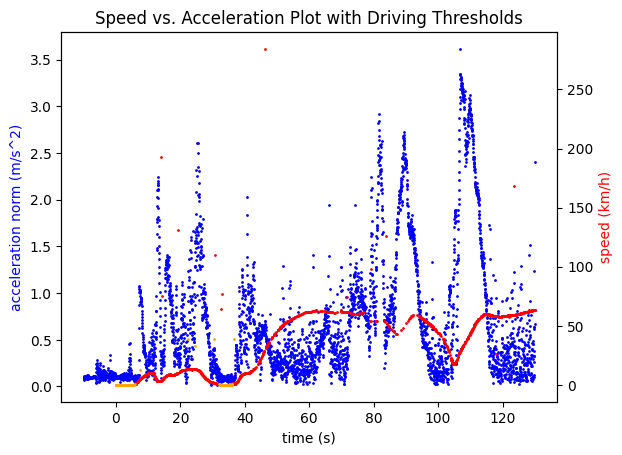

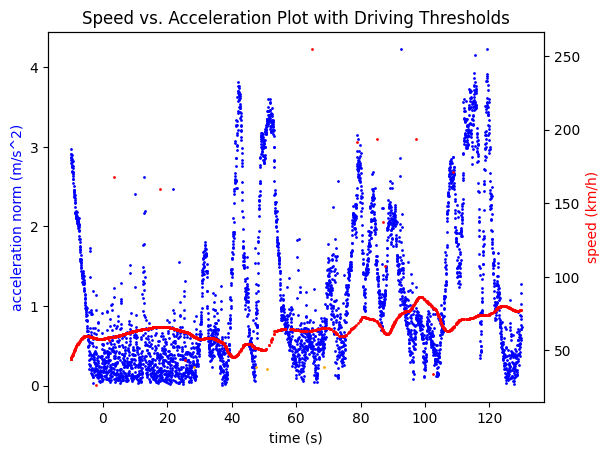

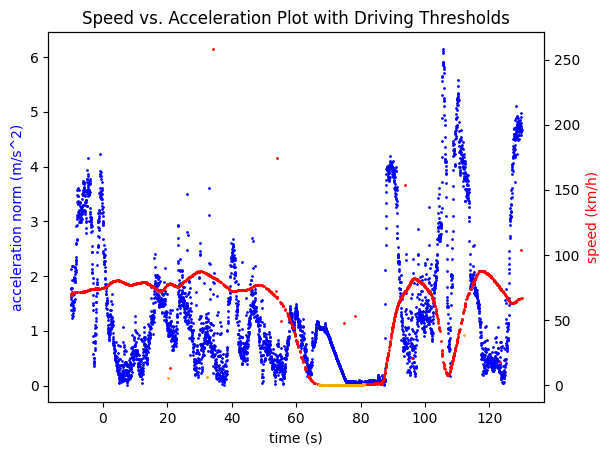

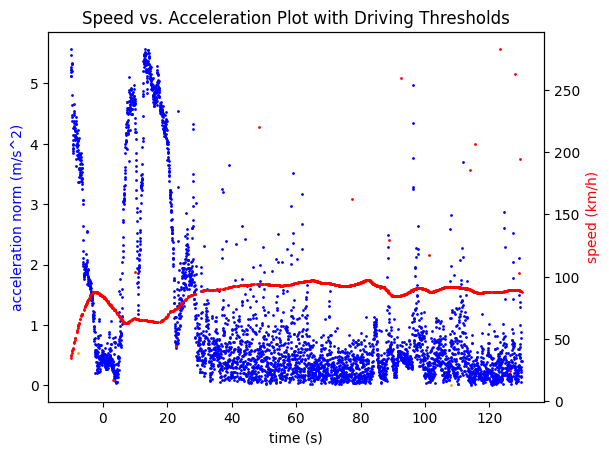

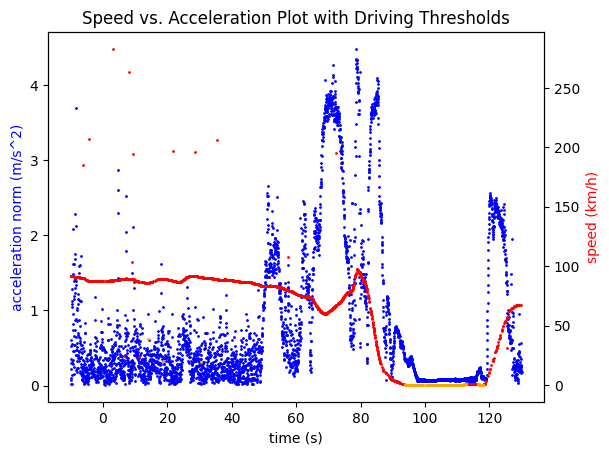

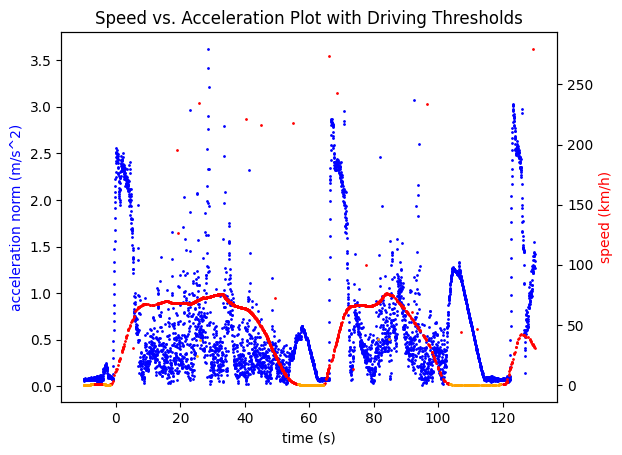

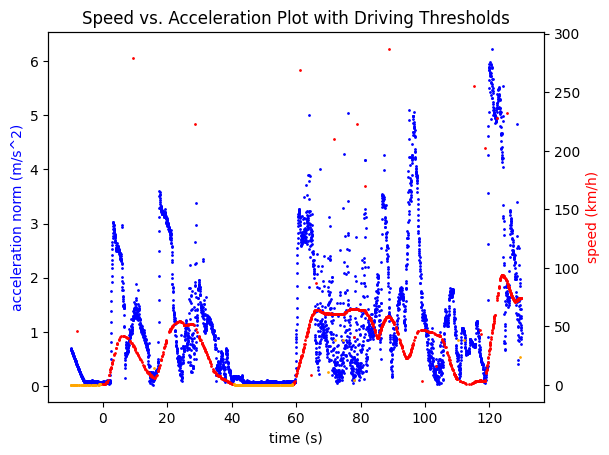

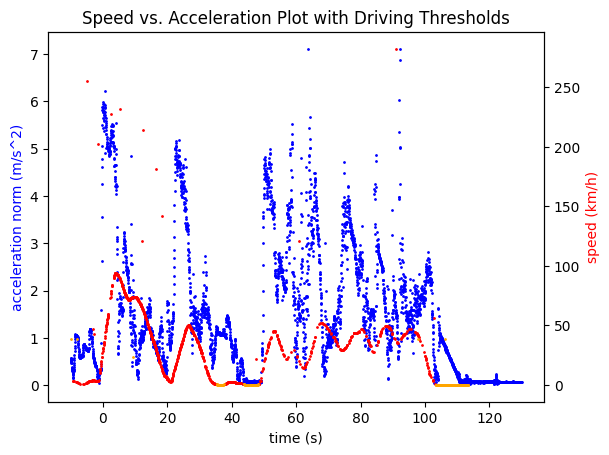

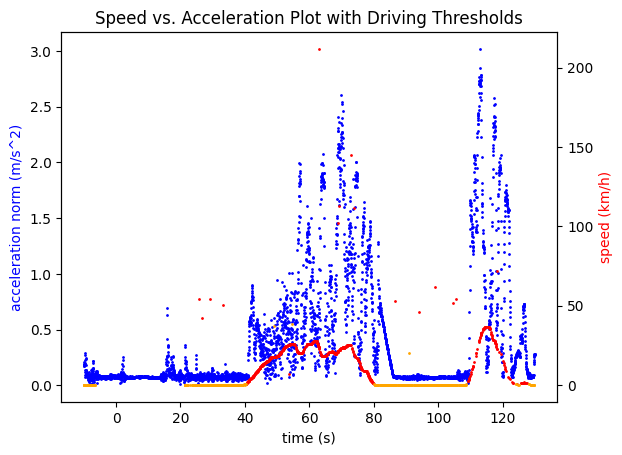

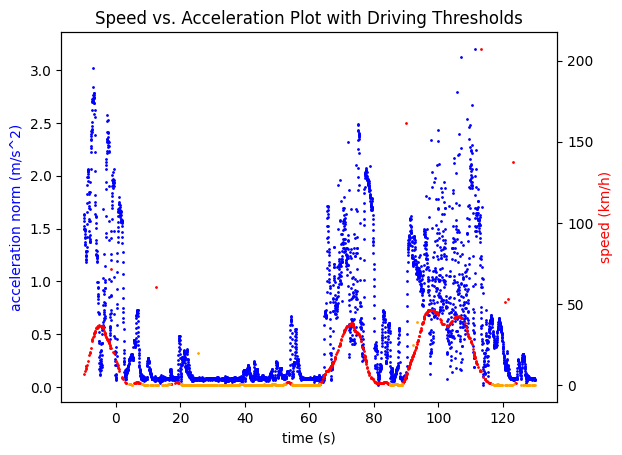

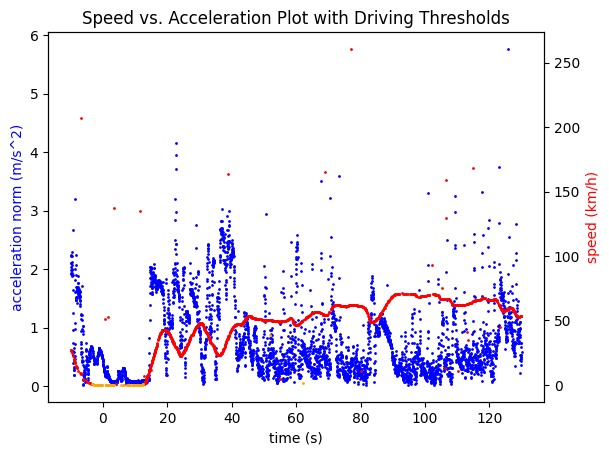

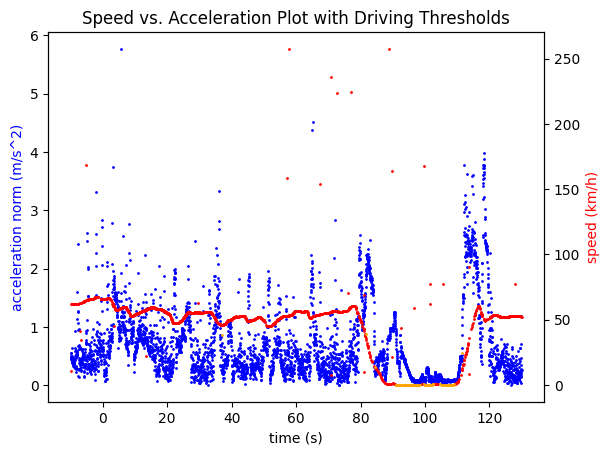

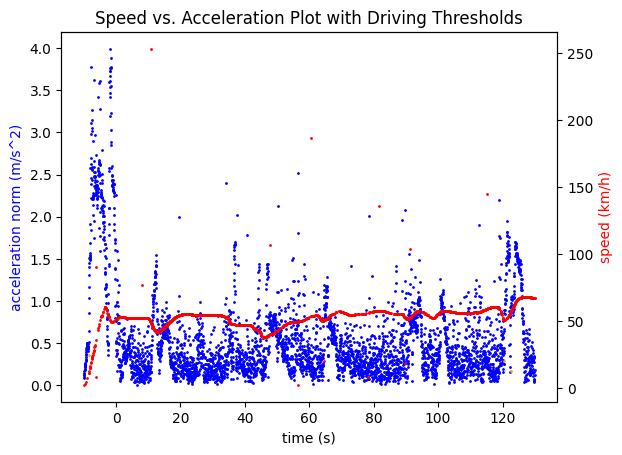

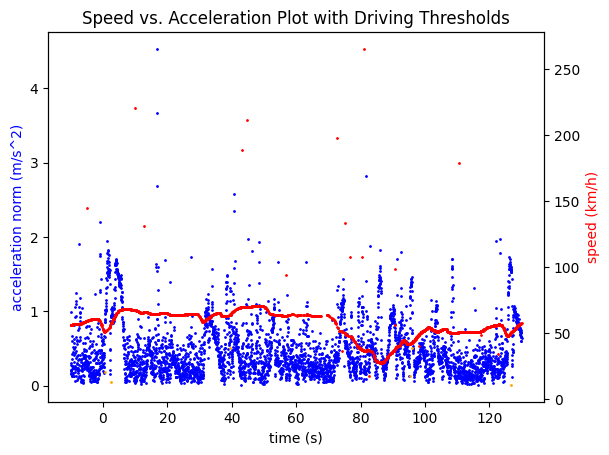

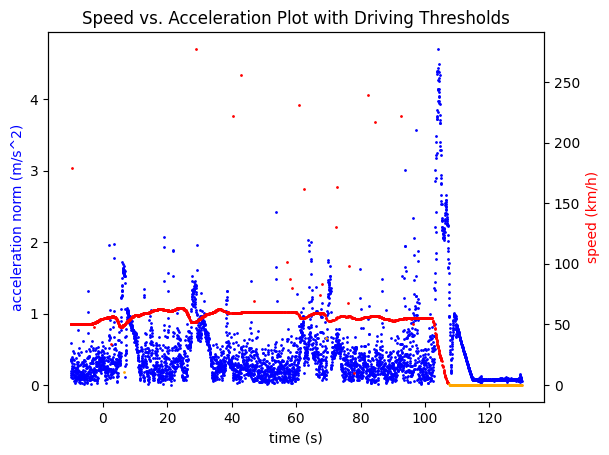

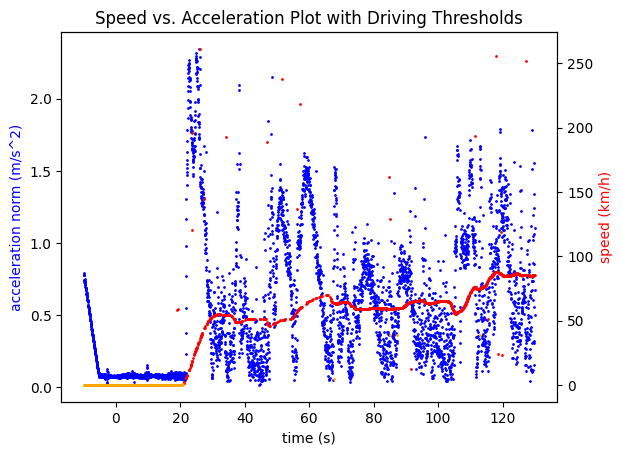

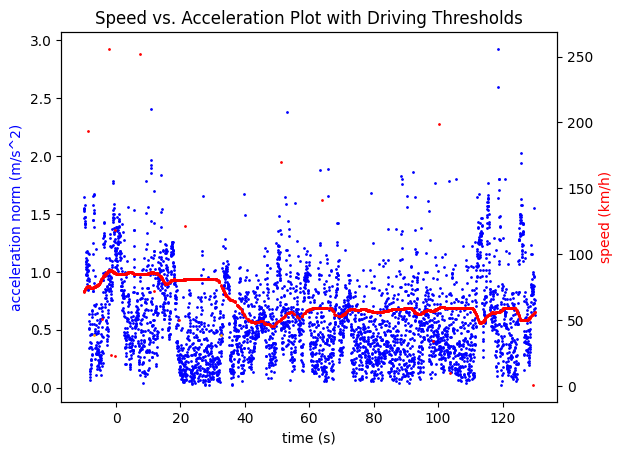

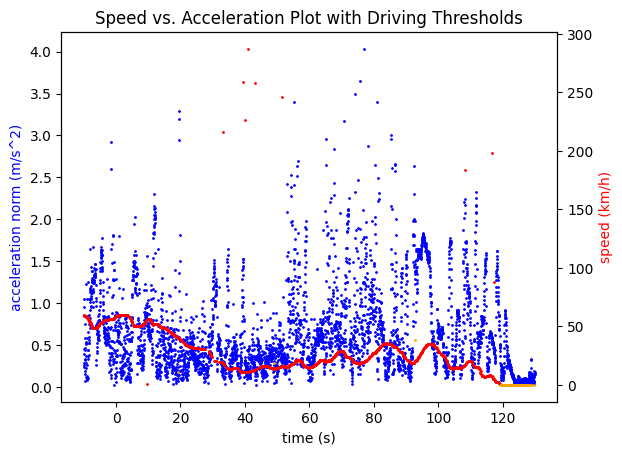

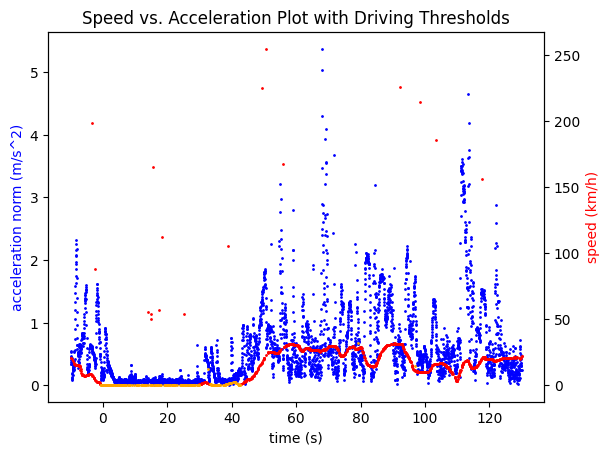

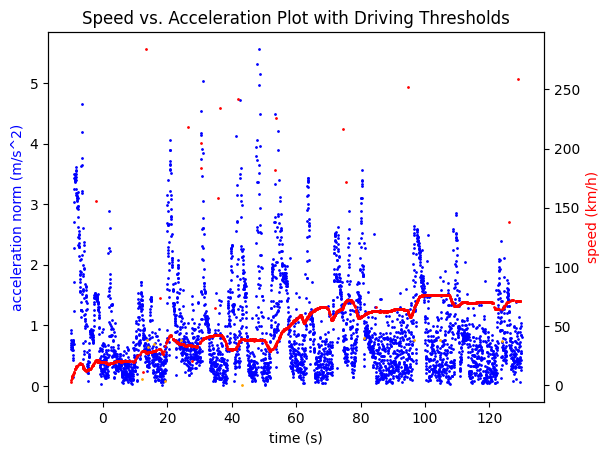

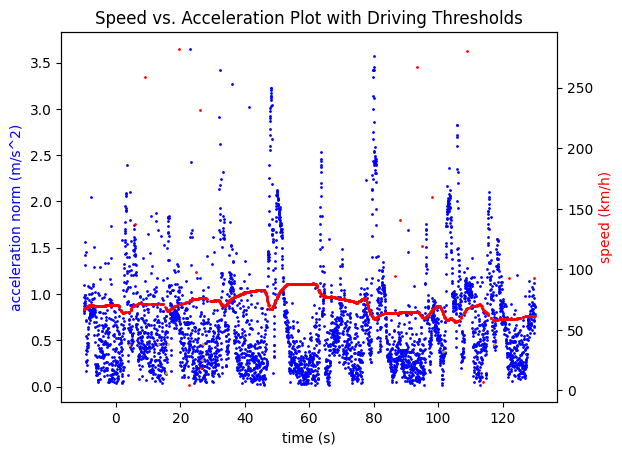

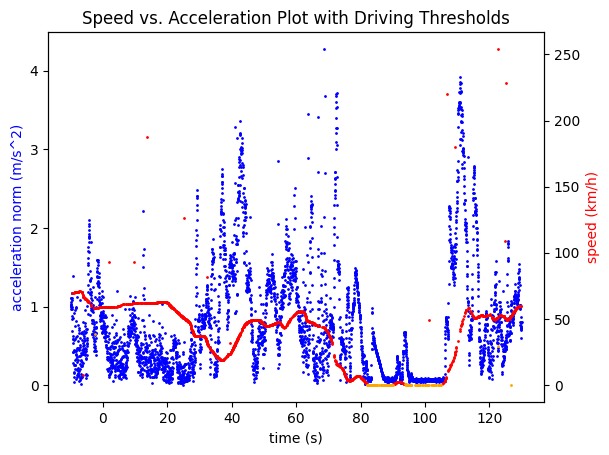

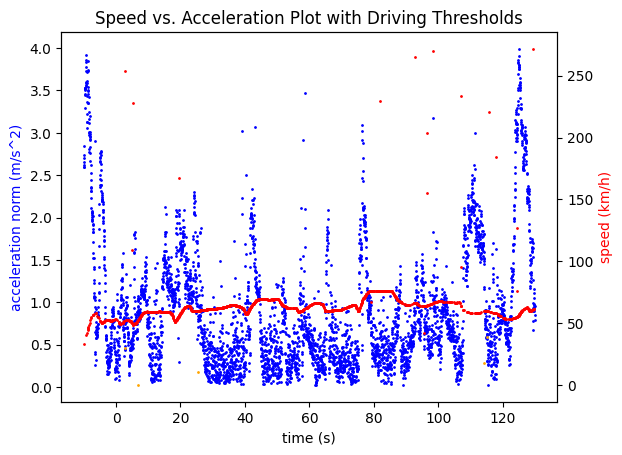

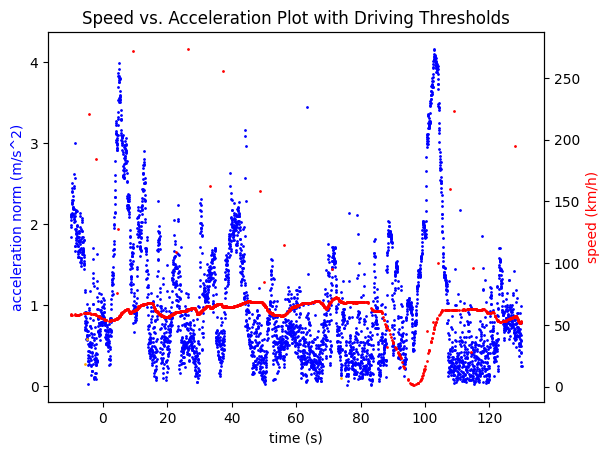

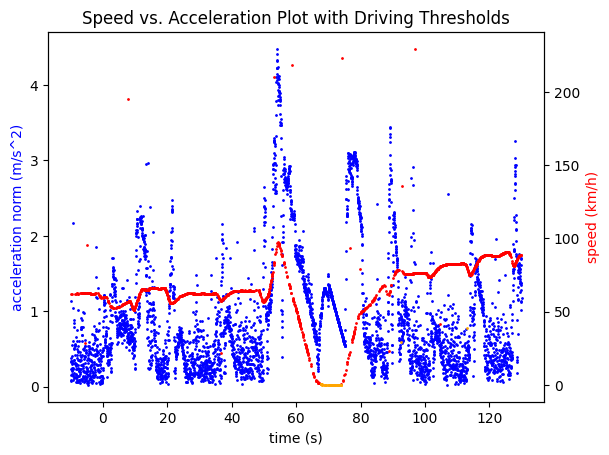

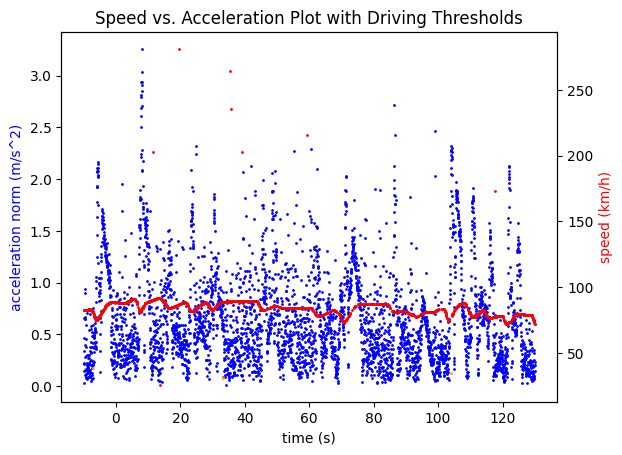

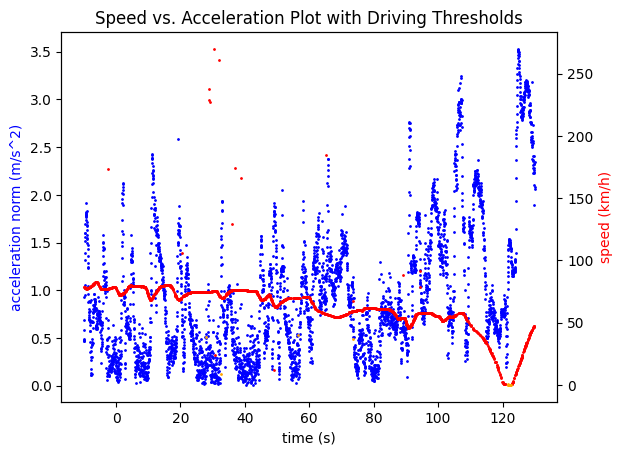

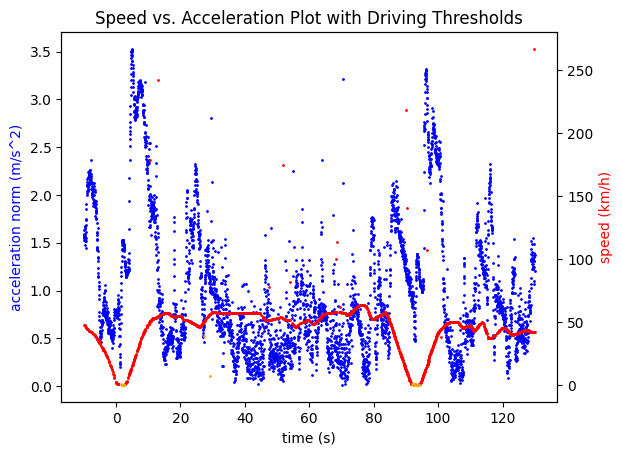

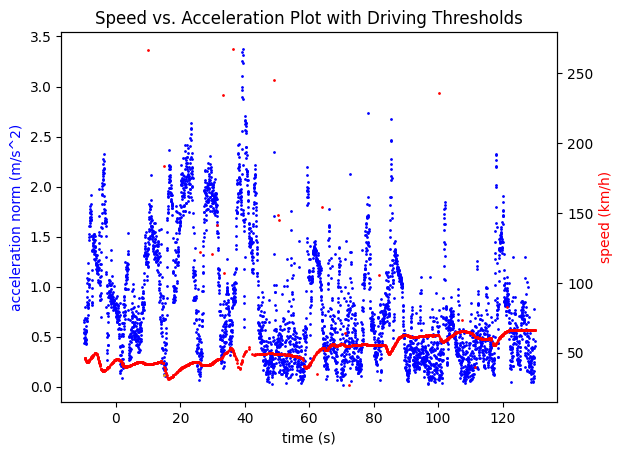

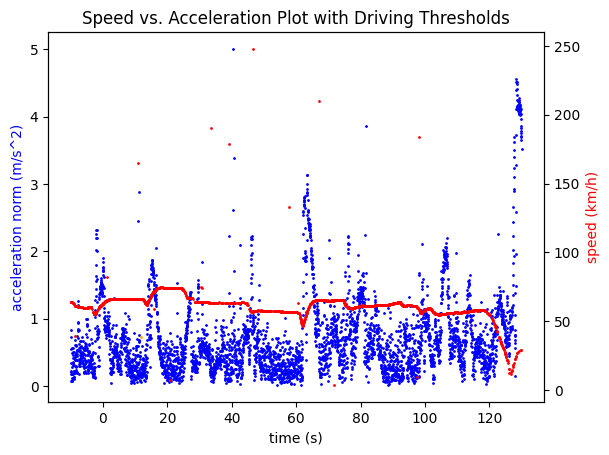

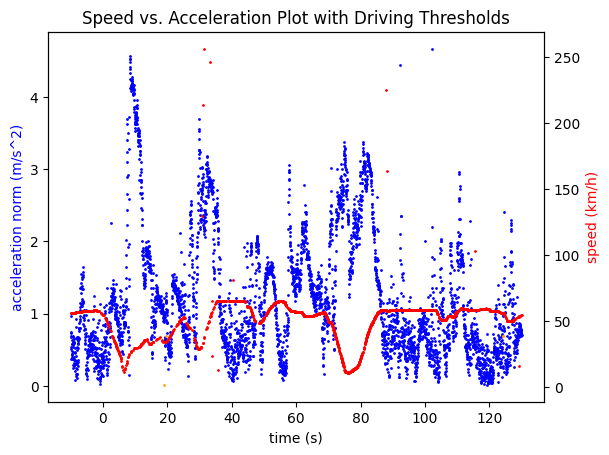

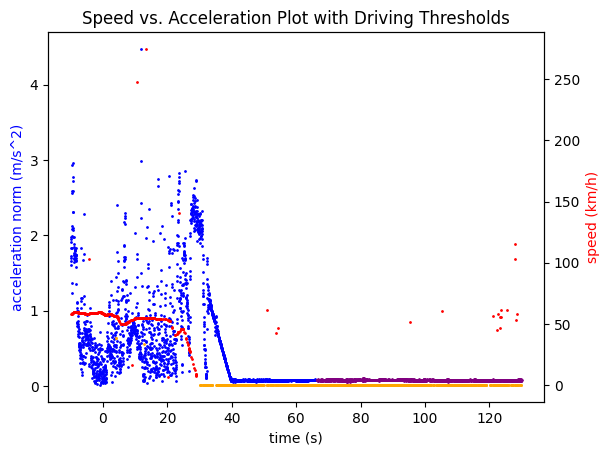

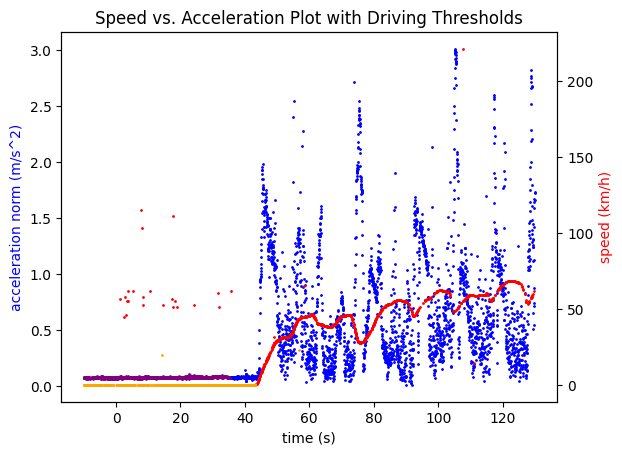

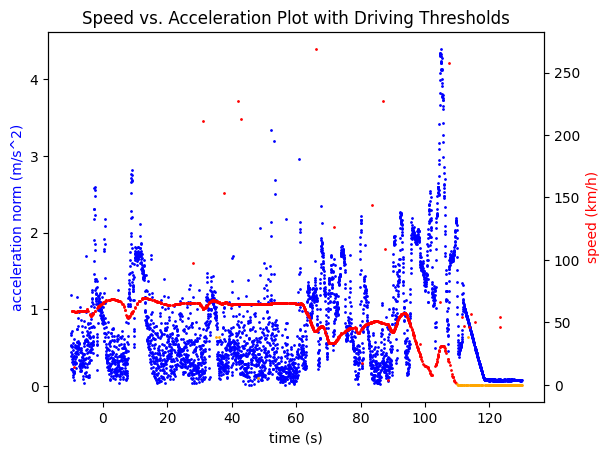

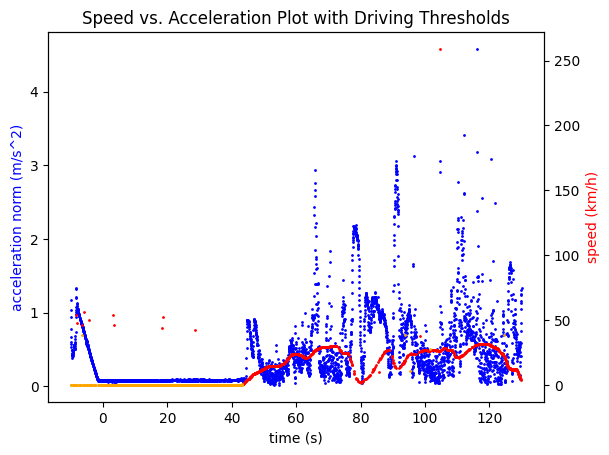

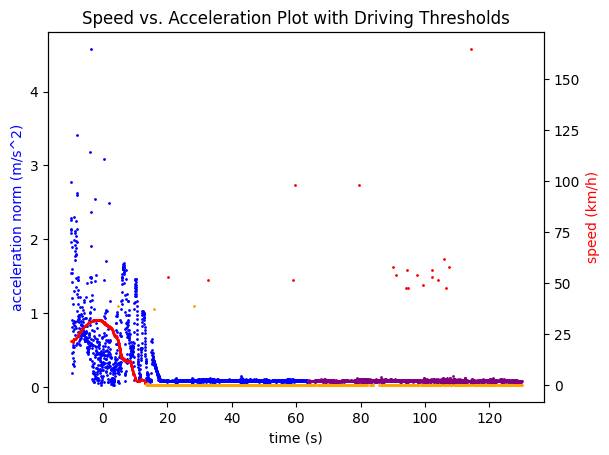

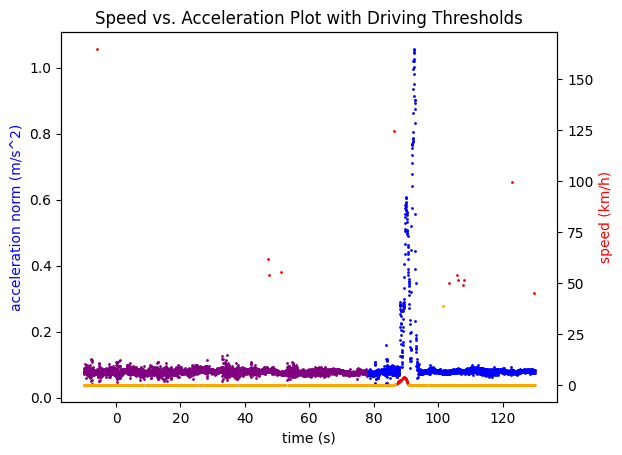

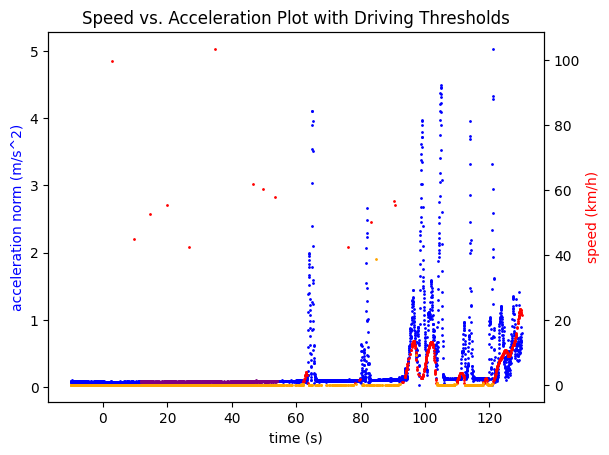

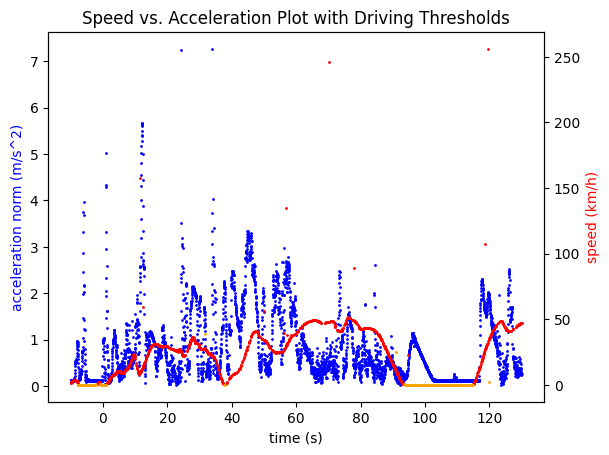

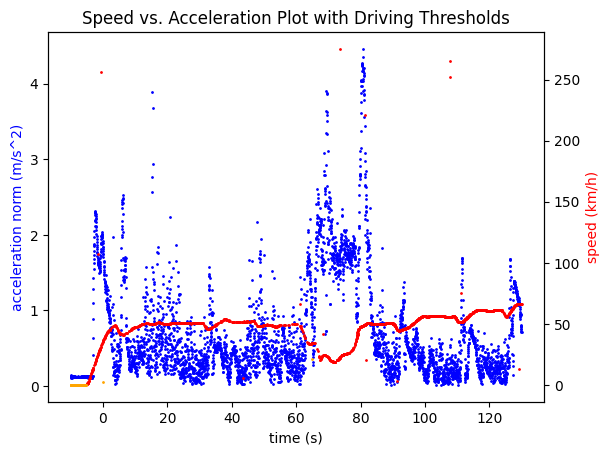

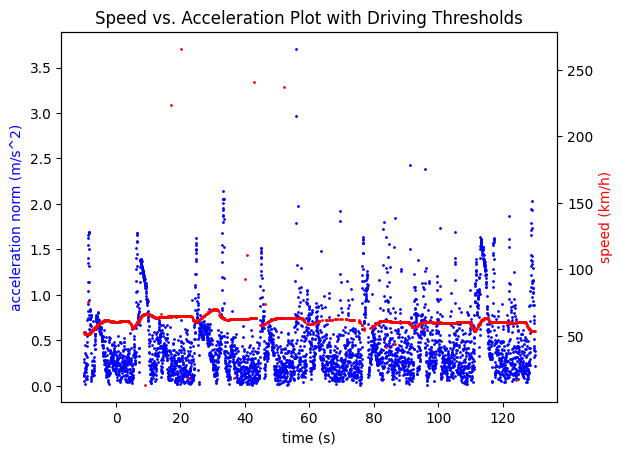

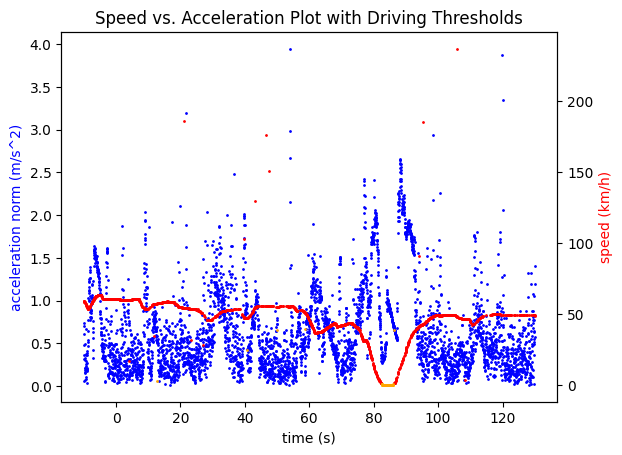

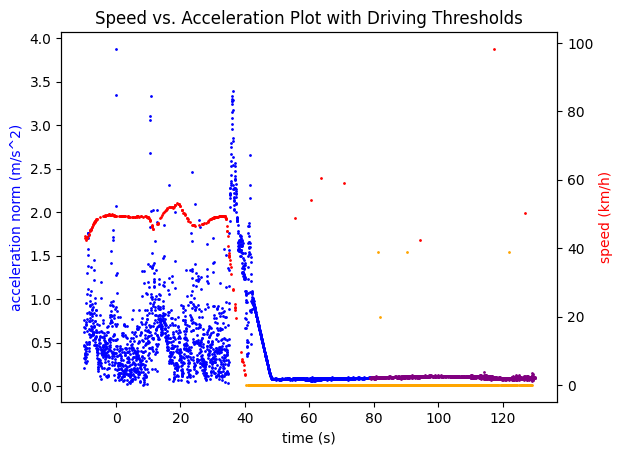

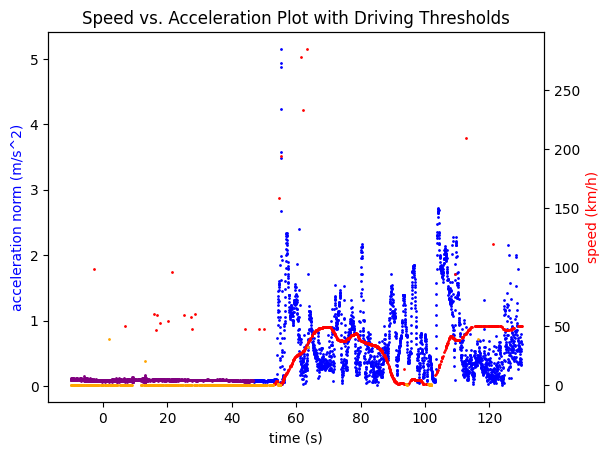

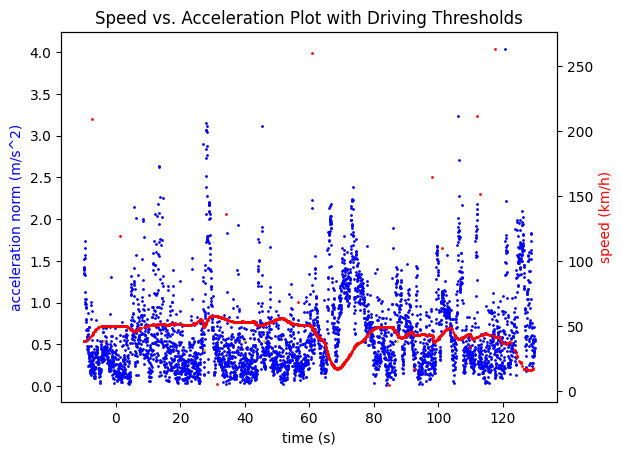

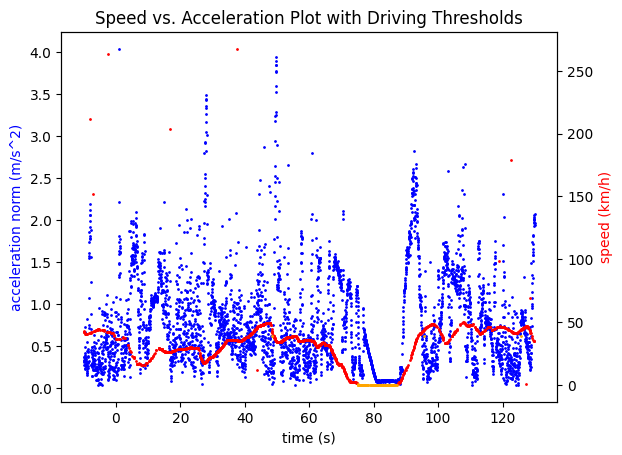

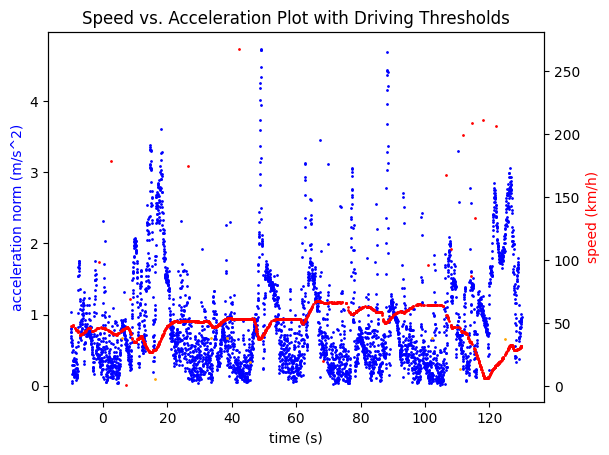

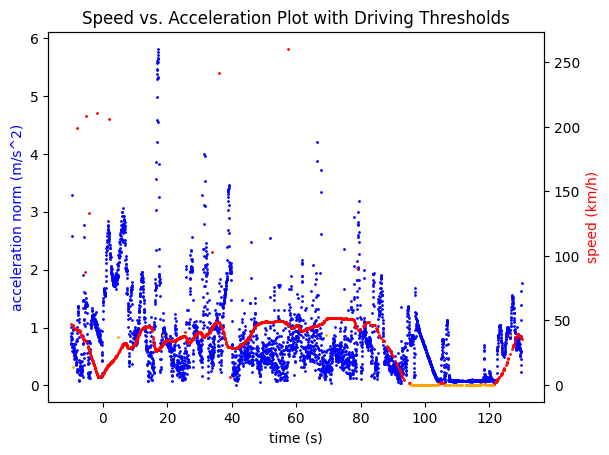

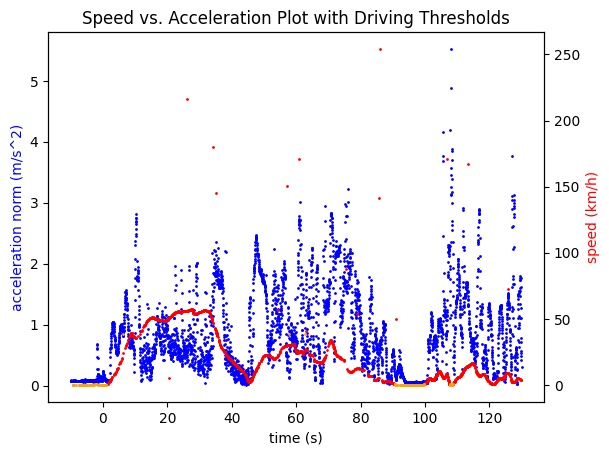

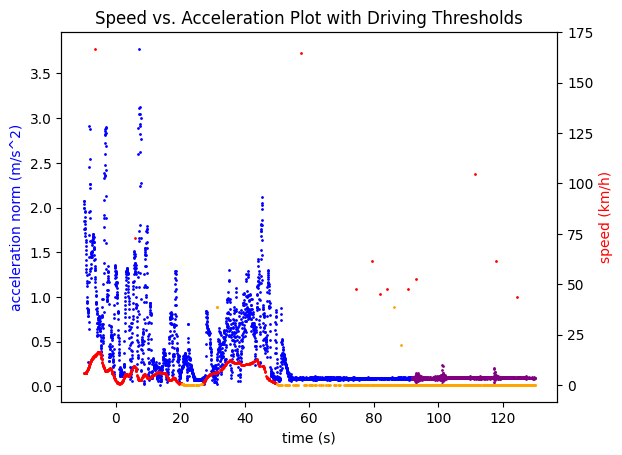

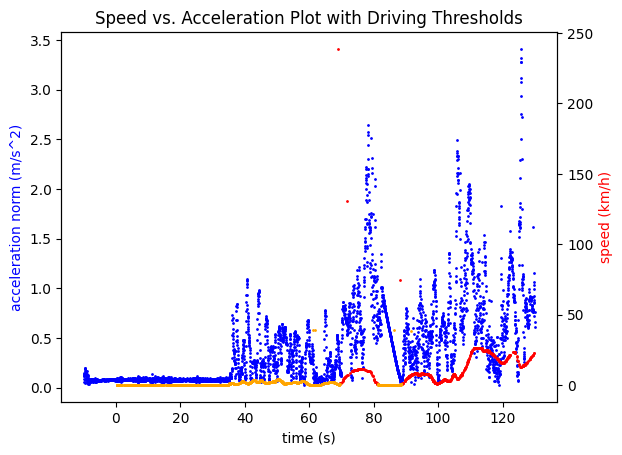

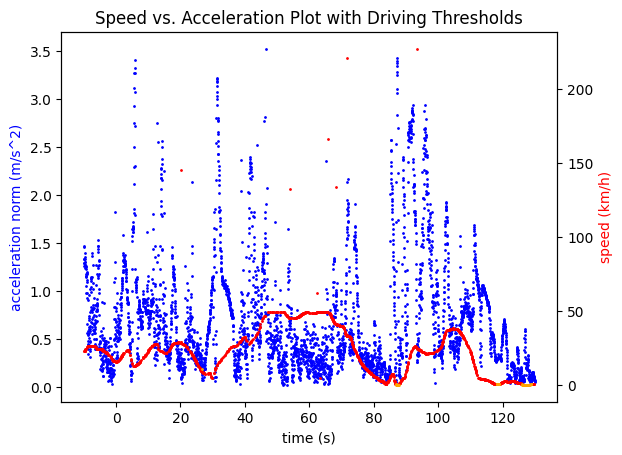

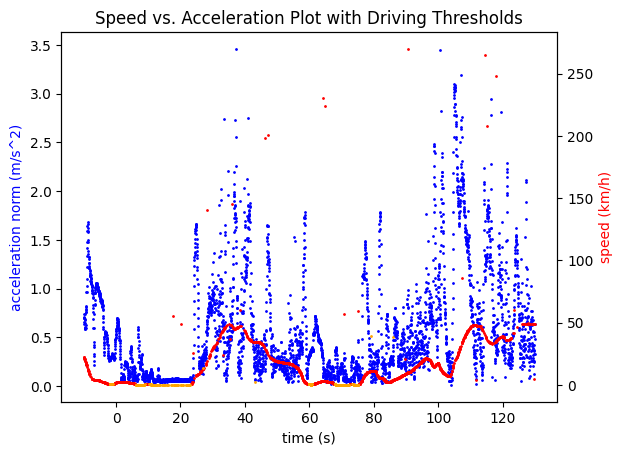

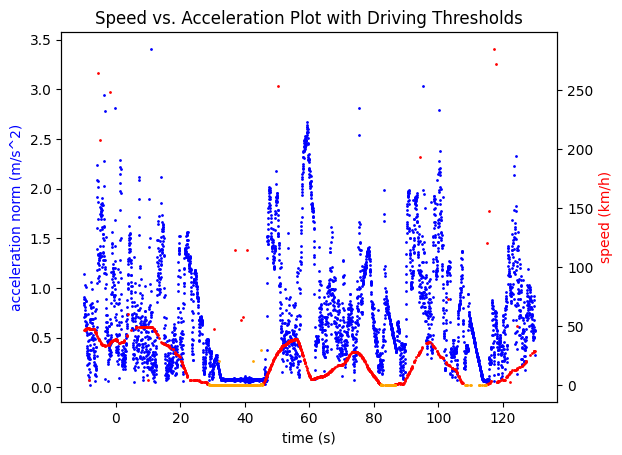

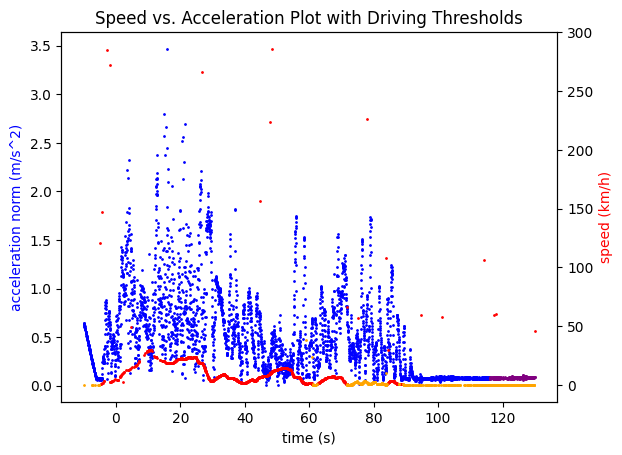

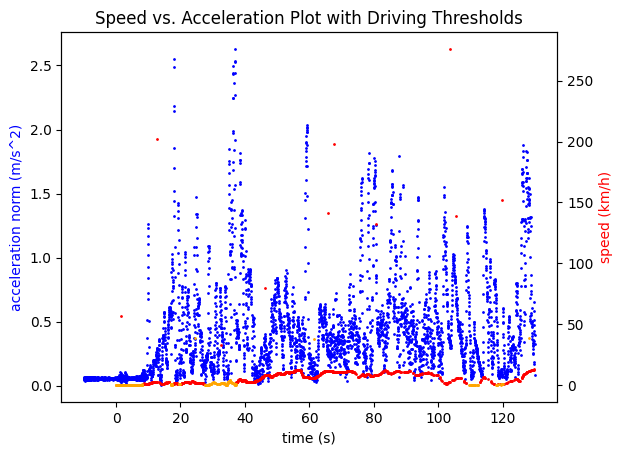

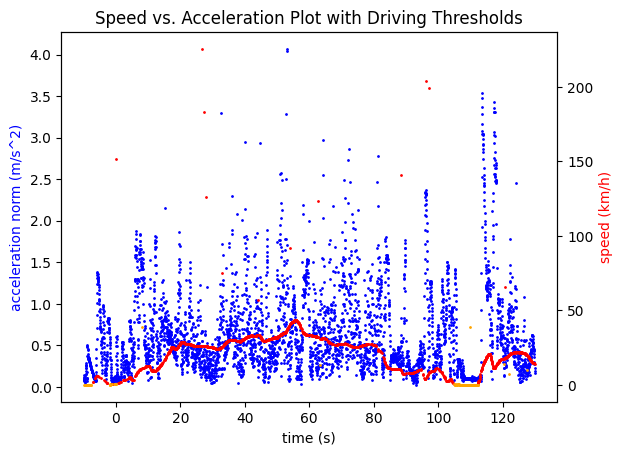

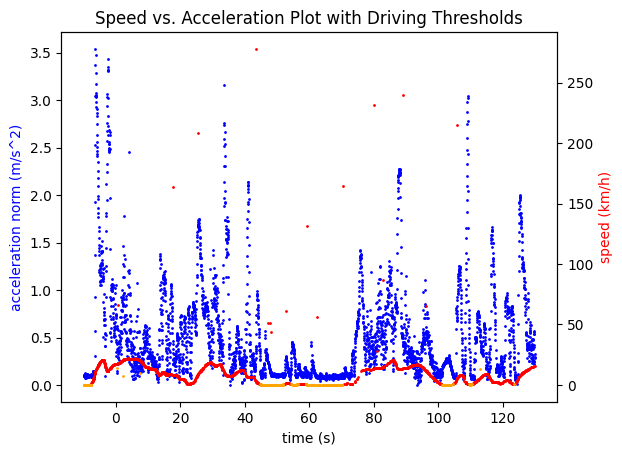

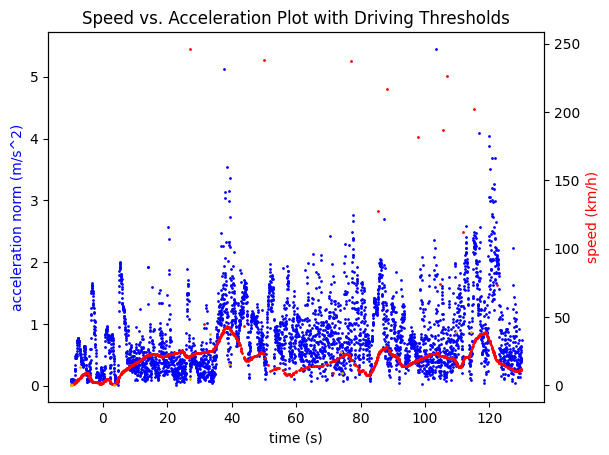

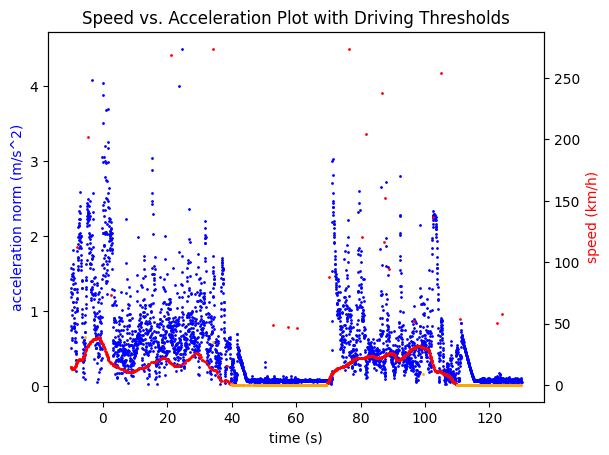

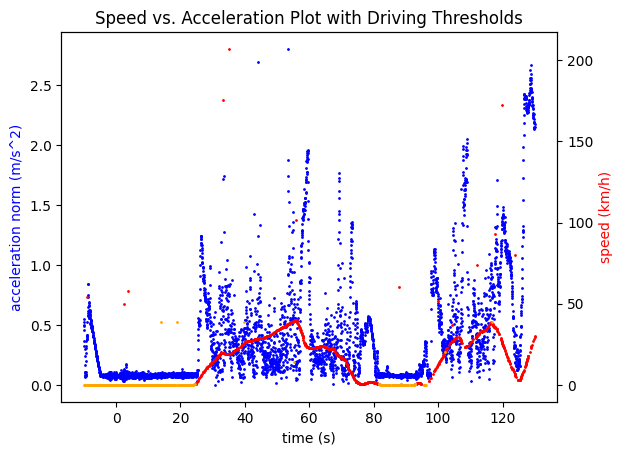

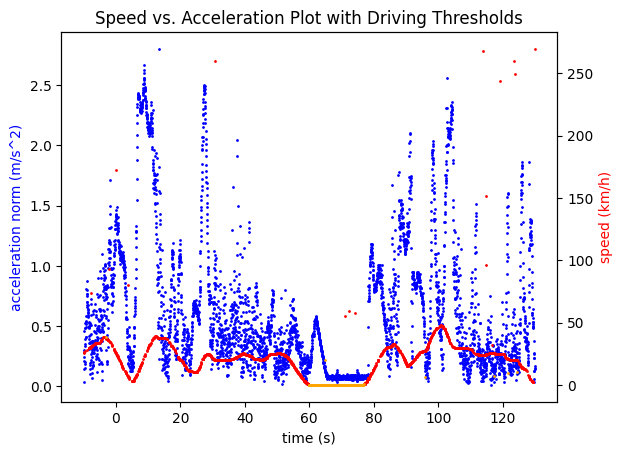

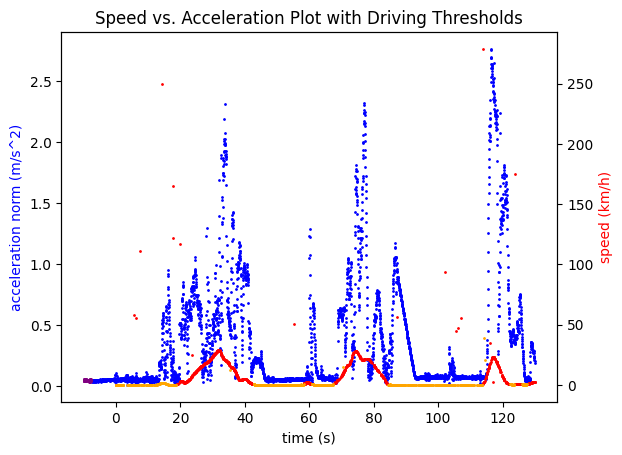

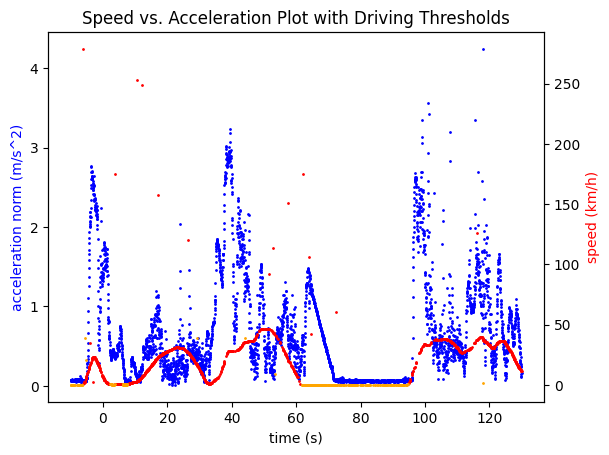

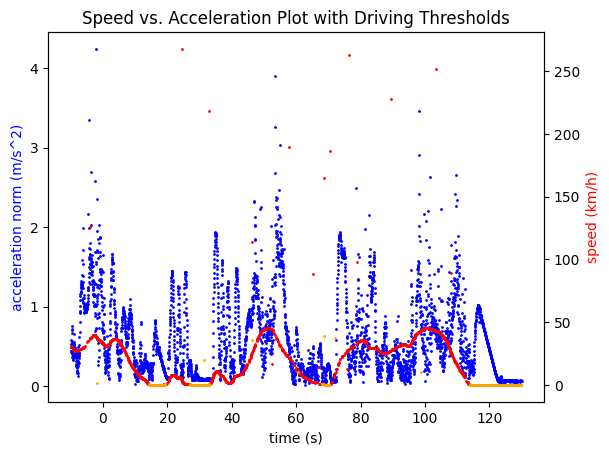

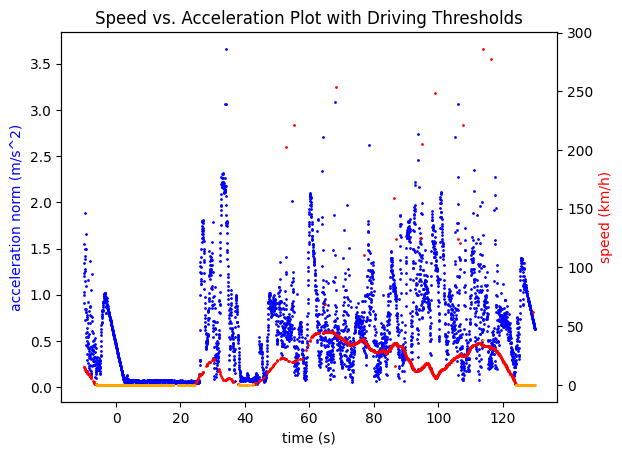

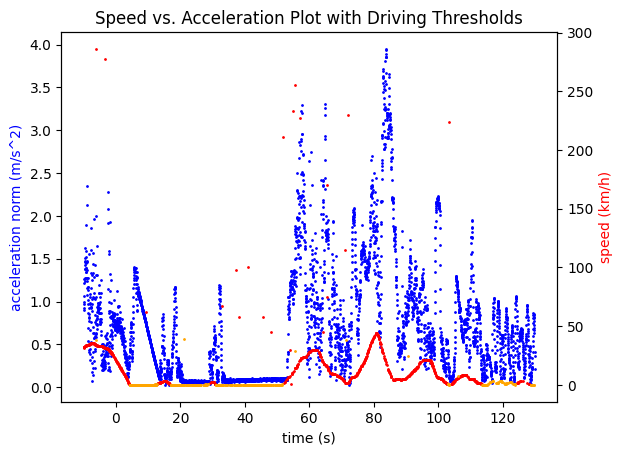

In [7]:
df_dr = imu_dr_df
df_ss = imu_ss_df
y_data = 'norm_acc'

window = 120
buffer = 10
count = 0

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        acc_dr = df_dr[(df_dr['correct_timestamp'] >= dr_start_time - buffer) 
                          & (df_dr['correct_timestamp'] <= dr_start_time + window + buffer)]
        acc_ss = df_ss[(df_ss['correct_timestamp'] >= dr_start_time - buffer) 
                          & (df_ss['correct_timestamp'] <= dr_start_time + window + buffer)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time - buffer) 
                            & (can_df['timestamp'] <= dr_start_time + window + buffer)]
        dr_start_time += window

        count += 1
        if ((len(acc_dr) + len(acc_ss) != 0) and (len(can_motion) != 0)):
            fig, ax1 = plt.subplots()

            can_dr = can_motion[can_motion['speed'] > 0.5]
            can_ss = can_motion[can_motion['speed'] <= 0.5]

            ax1.scatter(x=acc_dr['correct_timestamp'] - dr_start_time + window, y=acc_dr[y_data], s=1, color='blue')
            ax1.scatter(x=acc_ss['correct_timestamp'] - dr_start_time + window, y=acc_ss[y_data], s=1, color='purple')
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel('acceleration norm (m/s^2)', color='blue')

            ax2 = ax1.twinx()
            ax2.scatter(can_dr['timestamp'] - dr_start_time + window, abs(can_dr['speed']), color='red', s=1)
            ax2.scatter(can_ss['timestamp'] - dr_start_time + window, abs(can_ss['speed']), color='orange', s=1)
            ax2.set_ylabel('speed (km/h)', color='red')
            
            plt.title('Speed vs. Acceleration Plot with Driving Thresholds')

            plt.show()

In [20]:
# print(time_df)
time_df['system_clock(epoch)'].diff().median()
# imu_df['correct_timestamp'].diff().median()*100

23.559242725372314

Plot the IMU Data to see when we read high

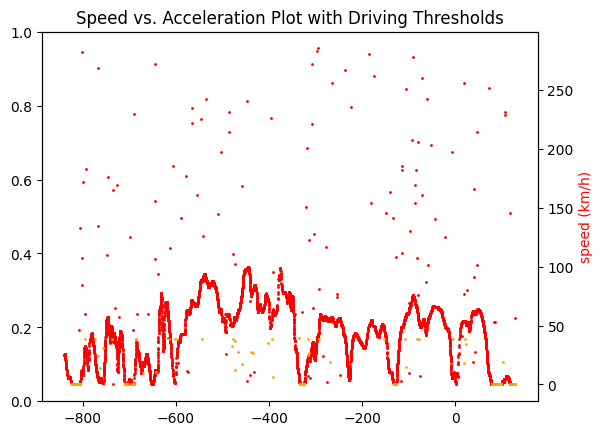

In [52]:
df_dr = imu_dr_df
df_ss = imu_ss_df
y_data = 'norm_acc'

window = 120
buffer = 1000

fig, ax1 = plt.subplots()

can_dr = can_motion[can_motion['speed'] > 0.5]
can_ss = can_motion[can_motion['speed'] <= 0.5]

ax1.scatter(x=df_dr['correct_timestamp'] - dr_start_time + window, y=df_dr[y_data], s=1, color='blue')
ax1.scatter(x=df_ss['correct_timestamp'] - dr_start_time + window, y=df_ss[y_data], s=1, color='purple')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('acceleration norm (m/s^2)', color='blue')

ax2 = ax1.twinx()
ax2.scatter(can_dr['timestamp'] - dr_start_time + window, abs(can_dr['speed']), color='red', s=1)
ax2.scatter(can_ss['timestamp'] - dr_start_time + window, abs(can_ss['speed']), color='orange', s=1)
ax2.set_ylabel('speed (km/h)', color='red')

plt.title('Speed vs. Acceleration Plot with Driving Thresholds')

plt.show()

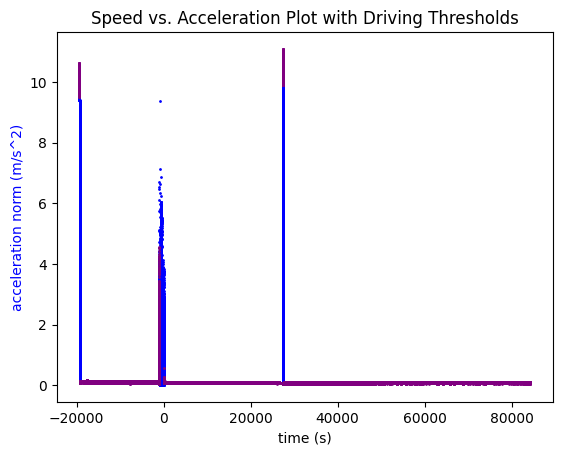

In [46]:
df_dr = imu_dr_df
df_ss = imu_ss_df
y_data = 'norm_acc'

window = 120
buffer = 1000

fig, ax1 = plt.subplots()

ax1.scatter(x=df_dr['correct_timestamp'] - dr_start_time + window, y=df_dr[y_data], s=1, color='blue')
ax1.scatter(x=df_ss['correct_timestamp'] - dr_start_time + window, y=df_ss[y_data], s=1, color='purple')
ax1.set_xlabel('time (s)')
ax1.set_ylabel('acceleration norm (m/s^2)', color='blue')
# ax1.set_xlim(27400, 27600)

plt.title('Speed vs. Acceleration Plot with Driving Thresholds')

plt.show()